# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
import matplotlib.pyplot as plt
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Load Data

In [4]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\K35400\AppData\Local\Temp\ipykernel_20644\1216095799.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\K35400\AppData\Local\Temp\ipykernel_20644\1216095799.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


#### Data Exploration
Befor we start working with the data, we should try to get an overview of the data. As mentioned, the datsets have almost identical columns, therefore we are exploring only one dataset and clean every dataset afterwards according to our findings in the `azdias` dataset.

#### Describing the Data

In [5]:
azdias_desc = azdias.describe()
azdias_desc

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


##### Missing Values

In [6]:
print('total number of values: % i' % azdias_desc.loc['count', 'LNR'])
azdias_desc.loc['count', :] - azdias_desc.loc['count', 'LNR']

total number of values:  891221


LNR                          0.0
AGER_TYP                     0.0
AKT_DAT_KL              -73499.0
ALTER_HH                -73499.0
ALTER_KIND1            -810163.0
                          ...   
WOHNDAUER_2008          -73499.0
WOHNLAGE                -93148.0
ZABEOTYP                     0.0
ANREDE_KZ                    0.0
ALTERSKATEGORIE_GROB         0.0
Name: count, Length: 360, dtype: float64

We can see here, that we have about 890k customers in our Dataset. We have a lot of missing data, which we can see in the anlysis above. Since we currently have no information about the importance of each column, it makes sense to keep the columns. Eventhough the importance is unknown, it is worth wile, trying simple methods to fill some of the missing data.

In [7]:
non_cols = (azdias_desc.loc['count', :] - azdias_desc.loc['count', 'LNR']) < 0
print("columns with missing values:")
print(len(azdias_desc.columns[non_cols]))

print("\nmissing values for each column:")
(azdias_desc.loc['count', :] - azdias_desc.loc['count', 'LNR']).loc[non_cols]

columns with missing values:
267

missing values for each column:


AKT_DAT_KL        -73499.0
ALTER_HH          -73499.0
ALTER_KIND1      -810163.0
ALTER_KIND2      -861722.0
ALTER_KIND3      -885051.0
                    ...   
VK_DISTANZ        -75917.0
VK_ZG11           -75917.0
W_KEIT_KIND_HH   -107602.0
WOHNDAUER_2008    -73499.0
WOHNLAGE          -93148.0
Name: count, Length: 267, dtype: float64

We can see, that a lot of columns with missing data have a similar amount of missing data. This may lead to the assumption that the missing data can be grouped in a specific way.

E.g.: the data containing `KBA05_*` all have the same amount of missing data. If we take a look at the description for this dataset, we can see that the data revolves around data related to cars and automotive in general, therefore we can assume that these missing data point can be imputed in the same way. The data will be imputed in the 'Data Cleaning' chapter.

In [8]:
missing_values = (azdias_desc.loc['count', :] - azdias_desc.loc['count', 'LNR']).loc[non_cols]
missing_values.value_counts()

-105800.0    116
-133324.0     64
-4854.0       19
-73499.0      11
-93148.0       9
-257113.0      8
-116515.0      7
-121196.0      3
-97274.0       3
-93155.0       3
-93740.0       3
-97216.0       3
-75917.0       3
-107602.0      2
-97786.0       2
-654153.0      1
-810163.0      1
-97008.0       1
-18348.0       1
-262947.0      1
-890016.0      1
-584612.0      1
-885051.0      1
-73969.0       1
-861722.0      1
-51226.0       1
Name: count, dtype: int64

##### Customers with missing values
Since we have a lot of data. We should consider dropping data from customers with a lot of missing data. Hence we should first take a look at how much missing data the customers usually have.


In [9]:
customer_nans = azdias.isna().sum(axis=1)

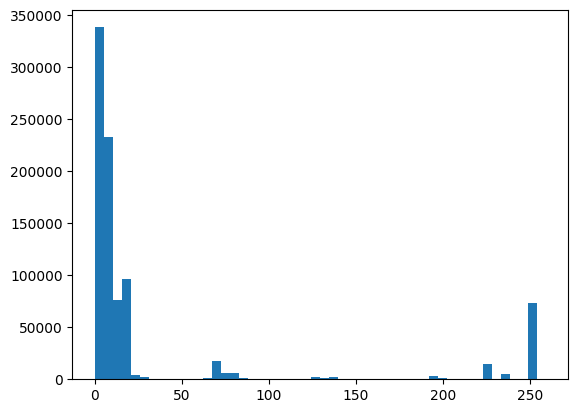

In [10]:
plt.hist(customer_nans, bins=50);

The histogram above shows, that most of the customers have less than approx. 30 missing values. We may consider dropping customers with more than 50 missing values.

##### Data Types
It seems like most of the data is categorical, but already transformed into numerical values. As we can see below, there are still a few categorical columns left. These have to be transformed into a numerical value as well. This will also be done in the following chapters.



In [11]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [12]:
azdias.columns[azdias.dtypes == 'object']

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

##### Duplicates
Another think to investigate is, if duplicates exist. Since the `azdias?` data has a unique id column (`LNR`), we are going to check for duplicates in this column.

In [13]:
azdias.LNR.duplicated().any()

False

##### Constant Values
Next, we are going to take a look at features with constant values, to see if we have features, that have no relevance.

In [14]:
has_unique_values = [len(icolumn.unique()) < 2 for _, icolumn in
                     azdias.items()]

In [15]:
has_unique_values.count(True)

0

We see that we have no problems wih duplicates in this dataset.

### Data Cleaning
To work with the data we have to take a look at the columns, the data formats and clean the data, to make the data more handy. Since the data is almost the same fo each file, except for a few columns, it makes sense to clean the data for each file in the same manor. Therefore, we are going to identify all the same columns and clean the data afterwards. The remaining columns are leaned seperately, since they dont have anything in common.

The data cleaning process will contain the following steps:
- drop or impute nans
- drop not useful customer-data
- transforming categorical data to numerical data

The evaluation of the useful customer-data will be postponed, first we have to analyse which features are actually important and which ones we can drop anyway. This will only be performed, if we see the necessity to do so.

##### Handle Nans

Since we have a lot of Nan values, it makes sense to replace them with an appropriate value.

###### Unify unknown data
We see that in the data we have some columns, that have different entries for unknown data. Usually, unknown has the flag `-1`, but in some cases it is set to `0` or to a tuple of values like `-1, 9` or `-1, 0`. To unify these entries, we are going to replace the values of `-1, 9` and `-1, 0` with `-1`, but we will still keep the `0`'s. The reason for that is, that in some cases like 'number of XY per household' it could be 0, but it could also be unknown. to keep that information, we are going to replace only the actually unknown data with `-1`'s.

In [16]:
def replace_unknowns(data):
    replace_dict = {'-1,0': '-1', '-1,9': '-1'}
    data.replace(replace_dict, regex=True, inplace=True)
    return data


azdias = replace_unknowns(azdias)

###### Dropping useless customers
Since we saw that a lot of customers have very few data and we have a lot of customer data, we can simply drop them. We are going to drop every row with more than 50 missing values.

In [17]:
azdias.shape

(891221, 366)

In [18]:
def drop_useless_rows(data):
    more_than_50_missing = data.isna().sum(axis=1) > 50
    index_50_missing = more_than_50_missing[more_than_50_missing].index
    data = data.drop(index_50_missing)

    return data

print(azdias.shape)
azdias = drop_useless_rows(azdias)
print(azdias.shape)

(891221, 366)
(751331, 366)


In [19]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


Eventhough we may have dropped about 15% of our data, but we are still left with a lot of data AND we gained additional data quality with low effort.

###### replace Nans
For every other non available value, we are going to set them the standard value of `-1`.

In [20]:
def replace_nans(data):
    data.fillna(-1, inplace=True)
    return data


azdias = replace_nans(azdias)
azdias

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,-1,9.0,0.0,-1.0,-1.0,-1.0,-1.0,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,-1.0,-1.0,-1.0,-1.0,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,-1.0,-1.0,-1.0,-1.0,13.0,1.0,...,0.0,7.0,10.0,11.0,-1.0,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,-1.0,-1.0,-1.0,-1.0,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,-1.0,-1.0,-1.0,-1.0,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,-1,5.0,17.0,-1.0,-1.0,-1.0,-1.0,17.0,15.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,-1,9.0,16.0,-1.0,-1.0,-1.0,-1.0,16.0,11.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,-1,1.0,17.0,-1.0,-1.0,-1.0,-1.0,17.0,3.0,...,2.0,7.0,10.0,8.0,-1.0,5.0,7.0,4,2,2
891219,825776,-1,9.0,0.0,17.0,-1.0,-1.0,-1.0,20.0,7.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


##### Transforming Categorical Data

First we have to identify which data is not categorical already. After that we are going to replace the columns with numerical values.

In [21]:
def get_non_numeric_columns(data):
    return data.columns[data.dtypes == 'object']


non_num_cols = get_non_numeric_columns(azdias)
non_num_cols

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

###### CAMEO_DEU_2015

In the data, we can see that the values range from 1 to 9 with additional letters from A to F. As we can see below in the CAMEO_DEUINT_2015 feature, the features are set to 11-55, but not consecutively, which we are going to do here as well.

In [22]:
azdias.loc[:, non_num_cols[0]].unique()

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '7A',
       '5D', '9E', '5C', '9B', '1B', '8B', '3D', -1, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [23]:
def clear_cameo_deu_2015_data(data):
    replace_dict = {'A': '1', 'B': '2', 'C': '3', 'D': '4', 'E': '5', 'F': '6',
                    'G': '7', 'H': '8', 'XX': '-1'}
    data.loc[:, 'CAMEO_DEU_2015'].replace(replace_dict, regex=True,
                                          inplace=True)
    data.loc[:, 'CAMEO_DEU_2015'] = data.loc[:, 'CAMEO_DEU_2015'].astype(int)
    return data


azdias = clear_cameo_deu_2015_data(azdias)
azdias.loc[:, 'CAMEO_DEU_2015'].head(10)

C:\Users\K35400\AppData\Local\Temp\ipykernel_20644\3161604245.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'CAMEO_DEU_2015'] = data.loc[:, 'CAMEO_DEU_2015'].astype(int)


1     81
2     43
3     21
4     62
5     83
6     41
7     24
8     11
9     15
10    94
Name: CAMEO_DEU_2015, dtype: int32

###### CAMEO_DEUG_2015
This Feature looks like most of the data is simply not an integer but rather mixed integers and float. In addition an X can be found in the data, which has to be replace by our standard value for unknown entries, `-1`.

In [24]:
azdias.loc[:, non_num_cols[1]].unique()

array([8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 7.0, 5.0, 3.0, -1, '3', '7', '2',
       '4', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [25]:
def clear_cameo_deug_2015_data(data):
    replace_dict = {'X': '-1'}
    data.loc[:, 'CAMEO_DEUG_2015'].replace(replace_dict, regex=True,
                                           inplace=True)
    data.loc[:, 'CAMEO_DEUG_2015'] = data.loc[:, 'CAMEO_DEUG_2015'].astype(int)

    return data


azdias = clear_cameo_deug_2015_data(azdias)
azdias.loc[:, non_num_cols[1]].unique()

C:\Users\K35400\AppData\Local\Temp\ipykernel_20644\2393891728.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'CAMEO_DEUG_2015'] = data.loc[:, 'CAMEO_DEUG_2015'].astype(int)


array([ 8,  4,  2,  6,  1,  9,  7,  5,  3, -1])

###### CAMEO_INTL_2015
This feature seems to have the same issue as `CAMEO_DEUG_2015`, hence we are going to apply the same methodology here

In [26]:
azdias.loc[:, non_num_cols[2]].unique()

array([51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 41.0, 34.0,
       55.0, 33.0, 25.0, -1, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '24', '41', '12', '54', '51', '44', '35', '23', '25', '14', '34',
       '52', '55', '31', '32', '22', '15', '13', '43', '45', '33', 'XX'],
      dtype=object)

In [27]:
def clear_cameo_intl_2015_data(data):
    replace_dict = {'XX': '-1'}
    data.loc[:, 'CAMEO_INTL_2015'].replace(replace_dict, regex=True,
                                           inplace=True)
    data.loc[:, 'CAMEO_INTL_2015'] = data.loc[:, 'CAMEO_INTL_2015'].astype(int)
    return data


azdias = clear_cameo_intl_2015_data(azdias)
azdias.loc[:, non_num_cols[2]].unique()

C:\Users\K35400\AppData\Local\Temp\ipykernel_20644\3076981586.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'CAMEO_INTL_2015'] = data.loc[:, 'CAMEO_INTL_2015'].astype(int)


array([51, 24, 12, 43, 54, 22, 14, 13, 15, 41, 34, 55, 33, 25, -1, 23, 31,
       52, 35, 45, 44, 32])

###### D19_LETZTER_KAUF_BRANCHE
Here we can see that this data is still categorical and not transformed to numerical code, like the other features, therefore, we are going to do that here.

In [28]:
azdias.loc[:, non_num_cols[3]].unique()

array([-1, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_SONSTIGE', 'D19_BANKEN_GROSS', 'D19_VOLLSORTIMENT',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_LEBENSMITTEL',
       'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'D19_SAMMELARTIKEL',
       'D19_TELKO_MOBILE', 'D19_REISEN', 'D19_BEKLEIDUNG_GEH',
       'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG', 'D19_DIGIT_SERV',
       'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_FREIZEIT',
       'D19_WEIN_FEINKOST', 'D19_GARTEN', 'D19_BILDUNG',
       'D19_BANKEN_LOKAL'], dtype=object)

In [29]:
def clear_d19_letzter_kauf_branche(data):
    data.loc[:, 'D19_LETZTER_KAUF_BRANCHE'] = pd.Categorical(
            data.loc[:, 'D19_LETZTER_KAUF_BRANCHE']).codes
    return data


azdias = clear_d19_letzter_kauf_branche(azdias)
azdias.loc[:, non_num_cols[3]].unique()

C:\Users\K35400\AppData\Local\Temp\ipykernel_20644\3276071408.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'D19_LETZTER_KAUF_BRANCHE'] = pd.Categorical(


array([ 0, 31, 25, 12, 18, 26,  2, 34, 11, 15,  9, 33, 32, 29,  1,  4, 19,
       16,  6, 24, 28, 23,  5, 27, 21, 10, 20, 22, 30, 17,  8, 13, 35, 14,
        7,  3], dtype=int8)

###### EINGEFUEGT_AM
This feature is just a date, which should be transformed in to a propper datetime object. But since we will not use this feature, we will drop that column.

In [30]:
azdias.loc[:, non_num_cols[4]].unique()

array(['1992-02-10 00:00:00', '1992-02-12 00:00:00',
       '1997-04-21 00:00:00', ..., '1994-10-24 00:00:00',
       '2000-03-09 00:00:00', '2005-03-19 00:00:00'], dtype=object)

In [31]:
azdias.loc[:, 'EINGEFUEGT_AM']

1         1992-02-10 00:00:00
2         1992-02-12 00:00:00
3         1997-04-21 00:00:00
4         1992-02-12 00:00:00
5         1992-02-12 00:00:00
                 ...         
891216    1992-02-10 00:00:00
891217    1992-02-10 00:00:00
891218    1992-02-10 00:00:00
891219    1992-02-12 00:00:00
891220    1992-02-10 00:00:00
Name: EINGEFUEGT_AM, Length: 751331, dtype: object

In [32]:
azdias.drop('EINGEFUEGT_AM', axis=1)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,-1,9.0,0.0,-1.0,-1.0,-1.0,-1.0,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,-1.0,-1.0,-1.0,-1.0,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,-1.0,-1.0,-1.0,-1.0,13.0,1.0,...,0.0,7.0,10.0,11.0,-1.0,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,-1.0,-1.0,-1.0,-1.0,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,-1.0,-1.0,-1.0,-1.0,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,-1,5.0,17.0,-1.0,-1.0,-1.0,-1.0,17.0,15.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,-1,9.0,16.0,-1.0,-1.0,-1.0,-1.0,16.0,11.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,-1,1.0,17.0,-1.0,-1.0,-1.0,-1.0,17.0,3.0,...,2.0,7.0,10.0,8.0,-1.0,5.0,7.0,4,2,2
891219,825776,-1,9.0,0.0,17.0,-1.0,-1.0,-1.0,20.0,7.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


###### OST_WEST_KZ
Here we have the same issue as with `D19_LETZTER_KAUF_BRANCHE`, therefore, we are going to clear them the same way.

In [33]:
azdias.loc[:, non_num_cols[5]].unique()

array(['W', 'O'], dtype=object)

In [34]:
def clear_ost_west_kz(data):
    data.loc[:, 'OST_WEST_KZ'] = pd.Categorical(
            data.loc[:, 'OST_WEST_KZ']).codes
    return data


azdias = clear_ost_west_kz(azdias)
azdias.loc[:, non_num_cols[5]].unique()

C:\Users\K35400\AppData\Local\Temp\ipykernel_20644\884617078.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'OST_WEST_KZ'] = pd.Categorical(


array([1, 0], dtype=int8)

### Summary
We will summarize the cleaning progress in an overall cleaning function and we are going to test that on the customer dataset.

In [35]:
common_columns = azdias.columns

def clear_data(data):
    temp_data = data.loc[:, common_columns]
    temp_data = handle_nans(temp_data)
    temp_data = clear_categorical_data(temp_data)

    return temp_data


def clear_categorical_data(data):
    data = clear_cameo_deu_2015_data(data)
    data = clear_cameo_deug_2015_data(data)
    data = clear_cameo_intl_2015_data(data)
    data = clear_d19_letzter_kauf_branche(data)
    data = clear_ost_west_kz(data)
    return data


def handle_nans(data):
    data = replace_unknowns(data)
    data = drop_useless_rows(data)
    data = replace_nans(data)
    return data


def test_data_types(data):
    return (data.dtypes != 'object').any()


In [36]:
customers = clear_data(customers)

C:\Users\K35400\AppData\Local\Temp\ipykernel_20644\3161604245.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'CAMEO_DEU_2015'] = data.loc[:, 'CAMEO_DEU_2015'].astype(int)
C:\Users\K35400\AppData\Local\Temp\ipykernel_20644\2393891728.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'CAMEO_DEUG_2015'] = data.loc[:, 'CAMEO_DEUG_2015'].astype(int)
C:\Users\K35400\AppData\Local\Temp\ipykernel_20644\3276071408.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values in

In [37]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,-1.0,-1.0,-1.0,-1.0,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
2,143872,-1,1.0,6.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,-1.0,-1.0,-1.0,-1.0,8.0,0.0,...,2.0,6.0,4.0,2.0,-1.0,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,-1.0,-1.0,-1.0,-1.0,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
5,143888,1,1.0,11.0,-1.0,-1.0,-1.0,-1.0,10.0,1.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3


In [38]:
test_data_types(customers)

True

In [39]:
azdias = clear_data(azdias)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Methodology
Since we have a lot of features and do not know their relevance regarding possible customers, we will keep all features. Most machine learning algorithms have a very long training time, we wil reduce the features, while still keeping the relevant information in the data.
To do so, we will reduce the dimension of the data using different dimension common dimension reduction algorithms like PCA, and ICA.

After we reduced the dimension of the data, we are going to cluster the data using the population data (`azdias`) and then predict the cluster for the customer dataset to see, if we can see differences in the distribution of the clusters.
Based on which dimension reduction algorithm helps

In [40]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import KernelPCA, FastICA, PCA
from sklearn.metrics.pairwise import manhattan_distances

cluster_pipeline_ica = Pipeline([
                                ('scaler', StandardScaler()),
                                ('dim_reduction', FastICA(n_components=120, max_iter=300)),
                                ('cluster', KMeans(n_clusters=12, n_init=15, max_iter=200, verbose=1))
                               ])

cluster_pipeline_pca = Pipeline([
                                ('scaler', StandardScaler()),
                                ('dim_reduction', PCA(n_components=0.90)),
                                ('cluster', KMeans(n_clusters=12, n_init=15, max_iter=200, verbose=1))
                               ])


def run_pipeline(pipeline, population, customers, plot_me=True):
    print('fitting pipeline')
    pipeline.fit(population)

    print('predicting for customers')
    index_cluster_customer = pipeline.predict(customers)
    index_cluster_customer = pd.DataFrame(index_cluster_customer)

    print('predicting for population')
    # get cluster density for whole population
    index_cluster_population = pipeline.predict(population)
    index_cluster_population = pd.DataFrame(index_cluster_population)

    if plot_me:
        print('plotting...')
        fig, ax = plt.subplots(1,2,sharex=True, figsize=(12, 4))

        ax[0].hist(index_cluster_population, bins=12);
        ax[0].set_title('Cluster distribution for whole population')

        ax[1].hist(index_cluster_customer, bins=12);
        ax[1].set_title('Cluster distribution for customers');

    return pipeline

import warnings
warnings.filterwarnings('ignore')

###### ICA + KMeans

In [41]:
from time import perf_counter

In [42]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,-1,9.0,0.0,-1.0,-1.0,-1.0,-1.0,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,-1.0,-1.0,-1.0,-1.0,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,-1.0,-1.0,-1.0,-1.0,13.0,1.0,...,0.0,7.0,10.0,11.0,-1.0,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,-1.0,-1.0,-1.0,-1.0,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,-1.0,-1.0,-1.0,-1.0,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


fitting pipeline
Initialization complete
Iteration 0, inertia 169.2987046933002.
Iteration 1, inertia 116.59927415458407.
Iteration 2, inertia 115.88819731540627.
Iteration 3, inertia 115.05567841142637.
Iteration 4, inertia 114.53630435587505.
Iteration 5, inertia 114.38838343112279.
Iteration 6, inertia 114.26024857814878.
Iteration 7, inertia 114.11845425201992.
Iteration 8, inertia 113.93495457055465.
Iteration 9, inertia 113.79085154864796.
Iteration 10, inertia 113.73794537517823.
Iteration 11, inertia 113.69028311505252.
Iteration 12, inertia 113.64474760054918.
Iteration 13, inertia 113.61697944655775.
Iteration 14, inertia 113.6009459541515.
Iteration 15, inertia 113.58729108794024.
Iteration 16, inertia 113.57752166488682.
Iteration 17, inertia 113.57049897135511.
Iteration 18, inertia 113.56473347397645.
Iteration 19, inertia 113.56032276335843.
Iteration 20, inertia 113.5573212655447.
Iteration 21, inertia 113.55544962926271.
Iteration 22, inertia 113.55429636422838.
Iterat

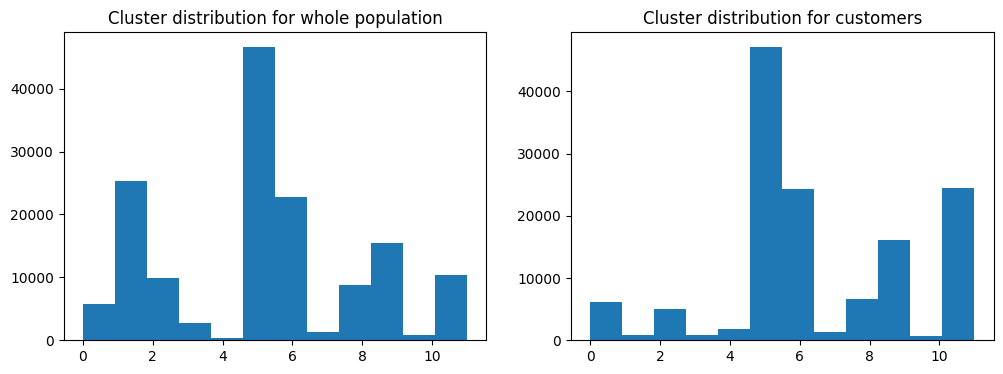

In [43]:
t0 = perf_counter()

pipeline_ica = run_pipeline(cluster_pipeline_ica,
                            azdias.drop('EINGEFUEGT_AM', axis=1).iloc[::5],
                            customers.drop('EINGEFUEGT_AM', axis=1))

print(perf_counter()-t0)

###### PCA + Kmeans

fitting pipeline
Initialization complete
Iteration 0, inertia 61819155.61258067.
Iteration 1, inertia 38489365.032922186.
Iteration 2, inertia 37734104.10995022.
Iteration 3, inertia 37451034.880158536.
Iteration 4, inertia 37334382.18059699.
Iteration 5, inertia 37290571.26619309.
Iteration 6, inertia 37268079.65954564.
Iteration 7, inertia 37252954.571994096.
Iteration 8, inertia 37242066.807599306.
Iteration 9, inertia 37233185.88086133.
Iteration 10, inertia 37225489.77736401.
Iteration 11, inertia 37217947.03154316.
Iteration 12, inertia 37210032.419219464.
Iteration 13, inertia 37201107.82673313.
Iteration 14, inertia 37190269.19367677.
Iteration 15, inertia 37176644.830072165.
Iteration 16, inertia 37161518.8073137.
Iteration 17, inertia 37148776.800609656.
Iteration 18, inertia 37140665.94012645.
Iteration 19, inertia 37136209.23968049.
Iteration 20, inertia 37133534.51275727.
Iteration 21, inertia 37131817.41854814.
Iteration 22, inertia 37130560.05728312.
Iteration 23, inerti

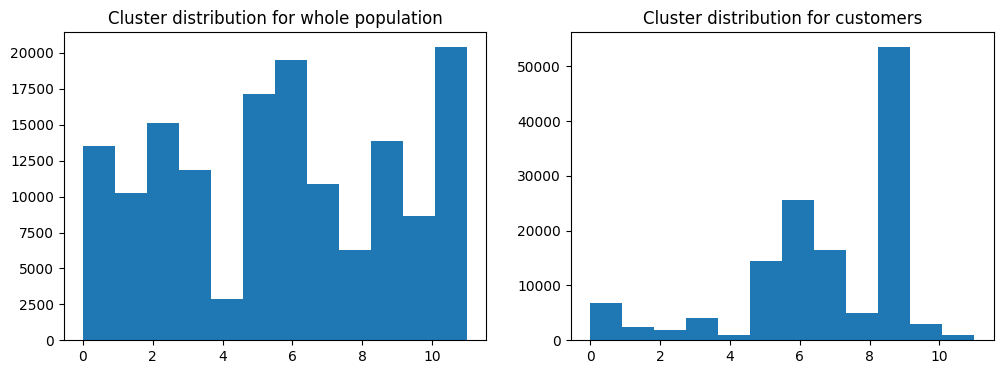

In [44]:
t0 = perf_counter()

pipeline_pca = run_pipeline(cluster_pipeline_pca,
                            azdias.drop('EINGEFUEGT_AM', axis=1).iloc[::5],
                            customers.drop('EINGEFUEGT_AM', axis=1))

print(perf_counter()-t0)

#### Conclusion
We can see that the PCA-dimension reduction works best with the KMeans clustering. We can see that the population is more homogeneously distributed and that the custoers generally belong to four main clusters. With that in mind, we are going to enrich our data with the clusters and then train our classifier in the next chapter with that information.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Intro
First we are going to load the data and clean them with the previously implemented cleaning function, with the additional `RESPONSE` column and seperate the labels from the data. After that, we are going to determine the clusters the training data is in and then train a classification model.
An overview of the following steps is listed below:
- Loading data
- Cleaning data
- Separating labels from features
- Run clustering pipeline on data
- Train classifier (with cross validation)
- Run classifier on test data

In [45]:
del azdias, customers

In [46]:
# added this to common columns, to keep this clean this column as well
common_columns = common_columns.append(pd.Index(['RESPONSE']))

In [47]:
common_columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB',
       'RESPONSE'],
      dtype='object', length=367)

### Load Data

In [48]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv',
        sep=';')

In [49]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


### Clean Data

In [50]:
print(mailout_train.shape)
mailout_train = clear_data(mailout_train)
mailout_train.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

(42962, 367)


In [51]:
print(mailout_train.shape)
mailout_train.head()

(34214, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
0,1763,2,1.0,8.0,-1.0,-1.0,-1.0,-1.0,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4,0
1,1771,1,4.0,13.0,-1.0,-1.0,-1.0,-1.0,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3,0
2,1776,1,1.0,9.0,-1.0,-1.0,-1.0,-1.0,7.0,0.0,...,6.0,4.0,2.0,-1.0,9.0,2.0,3,1,4,0
3,1460,2,1.0,6.0,-1.0,-1.0,-1.0,-1.0,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4,0
4,1783,2,1.0,9.0,-1.0,-1.0,-1.0,-1.0,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3,0


In [52]:
# get only who answered yes
mailout_yes_train = mailout_train[mailout_train.RESPONSE == 1]
# get only who answered no
mailout_no_train = mailout_train[mailout_train.RESPONSE == 0]

### Separate Features & Target

In [53]:
target_mailout = mailout_train.RESPONSE

In [54]:
feature_mailout = mailout_train.drop(['RESPONSE'], axis=1)

In [55]:
del mailout_train

### Clustering on Data-Set

In [56]:
yes_clusters = pipeline_pca.predict(mailout_yes_train.drop('RESPONSE', axis=1))
no_clusters = pipeline_pca.predict(mailout_no_train.drop('RESPONSE', axis=1))

Text(0.5, 1.0, 'negative response')

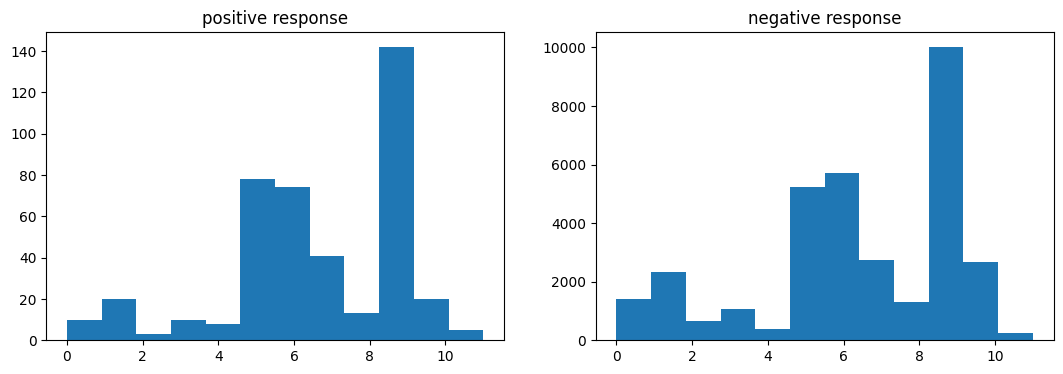

In [57]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(13,4))
ax[0].hist(yes_clusters,bins=12)
ax[0].set_title('positive response')
ax[1].hist(no_clusters,bins=12)
ax[1].set_title('negative response')


After applying the clustering algorithm on the mailout data, we can see that a pre-analysis on the data has already been performed and the data has already been pre-selected. The data shows the same distribution as our customers, hence the selected data is very similar to our customers data-set.
We can also see that the dataset is imbalanced and wen may need to adjust our classifier accordingly.

### Train Classifier
First we are going to setup a classification pipeline. After that, we are going to enrich the mailout data with the clusters from the previously trained clustering pipeline. Finaly we are going to train a classifier using SVM and optimizing it by using a gridsearch optimizer.
As we have seen, the dataset is imbalance, hence the best metrics to choose is the F1 score, therefore the TP values are "weighted" double.

In [58]:
from sklearn.svm import SVC

classifier_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(verbose=3))
])

gridsearch_params = gridsearch_params = {
    'classifier__C':[1, 2, 3],
    'classifier__kernel': ['linear']#, 'poly', 'rbf', 'sigmoid'],
    #'classifier__degree': [2, 3]
}

classifier_grid_searcher = GridSearchCV(classifier_pipeline, param_grid=gridsearch_params,
                             verbose=3, cv=3, scoring='f1', error_score="raise")

In [59]:
# enrich data
index_clusters = pipeline_pca.predict(feature_mailout)
feature_mailout['CLUSTER'] = index_clusters

In [60]:
feature_mailout.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CLUSTER
0,1763,2,1.0,8.0,-1.0,-1.0,-1.0,-1.0,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4,5
1,1771,1,4.0,13.0,-1.0,-1.0,-1.0,-1.0,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3,9
2,1776,1,1.0,9.0,-1.0,-1.0,-1.0,-1.0,7.0,0.0,...,6.0,4.0,2.0,-1.0,9.0,2.0,3,1,4,10
3,1460,2,1.0,6.0,-1.0,-1.0,-1.0,-1.0,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4,7
4,1783,2,1.0,9.0,-1.0,-1.0,-1.0,-1.0,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3,7


In [61]:
t0 = perf_counter()

pipeline_svm = classifier_grid_searcher.fit(feature_mailout.iloc[::4], target_mailout.iloc[::4])

print(perf_counter() - t0)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LibSVM][CV 1/3] END classifier__C=1, classifier__kernel=linear;, score=0.020 total time=   1.4s
[LibSVM][CV 2/3] END classifier__C=1, classifier__kernel=linear;, score=0.000 total time=   1.5s
[LibSVM][CV 3/3] END classifier__C=1, classifier__kernel=linear;, score=0.037 total time=   1.4s
[LibSVM][CV 1/3] END classifier__C=2, classifier__kernel=linear;, score=0.018 total time=   1.5s
[LibSVM][CV 2/3] END classifier__C=2, classifier__kernel=linear;, score=0.019 total time=   1.7s
[LibSVM][CV 3/3] END classifier__C=2, classifier__kernel=linear;, score=0.032 total time=   1.3s
[LibSVM][CV 1/3] END classifier__C=3, classifier__kernel=linear;, score=0.018 total time=   1.5s
[LibSVM][CV 2/3] END classifier__C=3, classifier__kernel=linear;, score=0.019 total time=   1.7s
[LibSVM][CV 3/3] END classifier__C=3, classifier__kernel=linear;, score=0.032 total time=   1.5s
[LibSVM]26.373013900000046


In [62]:
pred = pipeline_svm.predict(feature_mailout)
print(pipeline_svm.best_score_)
confusion_matrix(target_mailout, pred)

0.0230605084974017


array([[33431,   359],
       [  383,    41]], dtype=int64)

#### Handeling imbalanced data

We can see that the score for the classifier is very bad. This is probably due to the highly imbalanced data. There are different Methods to improve imbalanced data. The most basic one is to up- or downsample the data. We are going to try out both and see which one performs best.

##### Downsampling
With the downampling method, the number of the bigger class of data is reduced, to bring balance to the classes. Here we are reducing the number of people who did not react to the mails, to match the number of people who reacted positively.

In [64]:
feature_downsample = mailout_no_train.iloc[:len(mailout_yes_train)]
target_downsample = pd.concat([feature_downsample.loc[:, 'RESPONSE'], mailout_yes_train.loc[:, 'RESPONSE']])

feature_downsample = pd.concat([feature_downsample.drop('RESPONSE', axis=1), mailout_yes_train.drop('RESPONSE', axis=1)], axis=0)
feature_downsample.shape

(848, 365)

In [65]:
# enrich data
index_clusters = pipeline_pca.predict(feature_downsample)
feature_downsample['CLUSTER'] = index_clusters

t0 = perf_counter()

pipeline_svm = classifier_grid_searcher.fit(feature_downsample, target_downsample)

print(perf_counter() - t0)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LibSVM][CV 1/3] END classifier__C=1, classifier__kernel=linear;, score=0.536 total time=   0.0s
[LibSVM][CV 2/3] END classifier__C=1, classifier__kernel=linear;, score=0.577 total time=   0.0s
[LibSVM][CV 3/3] END classifier__C=1, classifier__kernel=linear;, score=0.592 total time=   0.0s
[LibSVM][CV 1/3] END classifier__C=2, classifier__kernel=linear;, score=0.536 total time=   0.0s
[LibSVM][CV 2/3] END classifier__C=2, classifier__kernel=linear;, score=0.577 total time=   0.0s
[LibSVM][CV 3/3] END classifier__C=2, classifier__kernel=linear;, score=0.592 total time=   0.1s
[LibSVM][CV 1/3] END classifier__C=3, classifier__kernel=linear;, score=0.536 total time=   0.0s
[LibSVM][CV 2/3] END classifier__C=3, classifier__kernel=linear;, score=0.577 total time=   0.0s
[LibSVM][CV 3/3] END classifier__C=3, classifier__kernel=linear;, score=0.592 total time=   0.0s
[LibSVM]2.269444099999987


In [66]:
pred = pipeline_svm.predict(feature_mailout)
print(pipeline_svm.best_score_)
confusion_matrix(target_mailout, pred)

0.5683596114491681


array([[19538, 14252],
       [   25,   399]], dtype=int64)

We can see that the F1-Score improved majorly, but we also see that the number of false positives improved majorly. Therefore this method brings an improvement, but is still not sufficient for our desires.
It should still be noted, that the cost for an additional email is not that high, such that more false positives is not necessarily a problem, but more false negatives woulds mean we did not reach out to customers who would "buy" our product. Hence we should definetly keep in mind, that a false negative is much worse than a false positive.

##### Upsampling
With upsampling we balance the data in an according way, compared to the downsampling but the other way around. We resample the few positive reactions, to match the number of negative reactions. That way, we get the data in balance and increase our data volume.

In [67]:
from sklearn.utils import resample

feature_upsampled = resample(mailout_yes_train,
                            replace=True,    # sample with replacement
                            n_samples= mailout_no_train.shape[0], # to match majority class
                            random_state=1)  # reproducible results

feature_upsampled = pd.concat([feature_upsampled, mailout_no_train], axis=0)

target_upsampled = feature_upsampled.RESPONSE

feature_upsampled.drop('RESPONSE', axis=1, inplace=True)

In [68]:
feature_upsampled.shape

(67580, 365)

In [69]:
# enrich data
index_clusters = pipeline_pca.predict(feature_upsampled)
feature_upsampled['CLUSTER'] = index_clusters

t0 = perf_counter()

pipeline_svm = classifier_grid_searcher.fit(feature_upsampled.iloc[::30], target_upsampled.iloc[::30])

print(perf_counter() - t0)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LibSVM][CV 1/3] END classifier__C=1, classifier__kernel=linear;, score=0.777 total time=   3.5s
[LibSVM][CV 2/3] END classifier__C=1, classifier__kernel=linear;, score=0.797 total time=   9.8s
[LibSVM][CV 3/3] END classifier__C=1, classifier__kernel=linear;, score=0.798 total time=   5.5s
[LibSVM][CV 1/3] END classifier__C=2, classifier__kernel=linear;, score=0.781 total time=   5.0s
[LibSVM][CV 2/3] END classifier__C=2, classifier__kernel=linear;, score=0.791 total time=  15.5s
[LibSVM][CV 3/3] END classifier__C=2, classifier__kernel=linear;, score=0.796 total time=  11.8s
[LibSVM][CV 1/3] END classifier__C=3, classifier__kernel=linear;, score=0.786 total time=   9.2s
[LibSVM][CV 2/3] END classifier__C=3, classifier__kernel=linear;, score=0.801 total time=  28.6s
[LibSVM][CV 3/3] END classifier__C=3, classifier__kernel=linear;, score=0.797 total time=  14.2s
[LibSVM]155.75210189999996


In [70]:
pred = pipeline_svm.predict(feature_mailout)
print(pipeline_svm.best_score_)
confusion_matrix(target_mailout, pred)

0.7942836893001605


array([[23890,  9900],
       [   71,   353]], dtype=int64)

We can see here that the performance improved majorly again, and we see that the miss rate is further reduced as well. Therefore, we should go with the upscaling method.

### Classify Test Dataset
Now its time to classify the test datset provided to see the performance on a test set.

#### Preprocess data

In [71]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [72]:
common_columns = common_columns.drop('RESPONSE')

In [73]:
print(mailout_test.shape)
mailout_test = clear_data(mailout_test)
mailout_test.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

print(mailout_test.shape)
mailout_test.head()

(42833, 366)
(34177, 365)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,-1.0,-1.0,-1.0,-1.0,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,-1.0,-1.0,-1.0,-1.0,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,...,2.0,6.0,6.0,3.0,-1.0,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,-1.0,-1.0,-1.0,-1.0,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


#### Run Classifier on test data

In [74]:
# enrich data
index_clusters = pipeline_pca.predict(mailout_test)
mailout_test['CLUSTER'] = index_clusters

In [75]:
response_test = pipeline_svm.predict(mailout_test)

In [76]:
pd.to_pickle(response_test, 'data/RESULT_mailout_test.pkl')

## Part 3: Conclusion
I have shown how to cluster and separate the customer group from the whole population using PCA for dimensionality reduction and KMeans for the clustering. PCA was also compared to ICA, but since the ICA clusters were not as clearly seperable as the clusters created with the PCA, PCA was chosen.

After that, a clustering pipeline was trained to enhance the dataset provided to train a classifier. This data was cleaned, clustered and categorised.
To classify the data correctly, a gridsearch was performed using SVM as a classifier.
It was shown that the linear kernel was not only very fast for training but also performs best for the optimization. The metrics optimized was the F1 Score, since the data was highly imbalanced.

To handle the imbalance in the data, the data was upscaled, which improved the performance significantly.

### Further improvements
To further improve the classifier, there are a few things that can be changed.

First of all, different clustering and classifying algorithms can be compared to each other. Here we only took a look at one because the main problem here was that the data was highly imbalanced, but it is worth trying out other algorithms like DBScan for the clustering or XGBoost, Random Forest or even a Neural Network for classification as well.

In addition, more advanced techniques to handle imbalanced data can be applied, such as SMOTE or a Balance Bagging Classifier ([Further details here](https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/)).